# ActivitySim Verification
ActivitySim verification and visualization

Ben Stabler, ben.stabler@rsginc.com, 02/22/19

Blake Rosenthal, blake.rosenthal@rsginc.com, 11/15/19

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openmatrix as omx
import os

## Utilities

Path setup and useful verification methods. Specify the example directory you wish to run/verify.

In [2]:
EXAMPLE_DIR = '../example'
VERIF_DIR = os.path.join(EXAMPLE_DIR, 'verification')
%mkdir $VERIF_DIR

def save_verf_csv(dataframe, filename,
                  index=True, header=True, na_rep=0):
    path = os.path.join(VERIF_DIR, filename)
    dataframe.to_csv(path, header=header, index=index, na_rep=na_rep)

mkdir: ../example/verification: File exists


## ✨ Run ✨

(optional) The example can be run directly from this notebook

In [3]:
simulation_script = 'simulation.py'
%cd $EXAMPLE_DIR
# %run $simulation_script

/Users/blake.rosenthal/src/activitysim/example


## Settings

In [4]:
SP = False  # process work/sch shadow pricing comparisons

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

## Inputs

These might need to change depending on which example has been run! Check your example folder for exact file names.

In [5]:
ZONES_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_land_use.csv')
ACCESS_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_accessibility.csv')
PERSON_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_persons.csv')
HH_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_households.csv')
TOUR_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_tours.csv')
TRIPS_FILE = os.path.join(EXAMPLE_DIR, 'output', 'final_trips.csv')

DISTANCE_MATRIX_FILE = os.path.join(EXAMPLE_DIR, 'data', 'skims.omx')
NMTF_ALTS_FILE = os.path.join(EXAMPLE_DIR, 'configs', 'non_mandatory_tour_frequency_alternatives.csv')

# SP_WORK_FILE = "asim/shadow_price_workplace_modeled_size_10.csv"
# SP_SCHOOL_FILE = "asim/shadow_price_school_modeled_size_10.csv"
# SP_SCHOOL_NO_SP_FILE = "asim/shadow_price_school_modeled_size_1.csv"

for file in [ZONES_FILE,
             ACCESS_FILE,
             PERSON_FILE,
             HH_FILE,
             TOUR_FILE,
             TRIPS_FILE,
             DISTANCE_MATRIX_FILE,
             NMTF_ALTS_FILE]:
    if not os.path.exists(file):
        raise FileNotFoundError("Make sure %s exists before proceding to next step!" % file)

(Optional) Specify a shapefile to plot zone data. Note that `geopandas` and its dependencies must be installed.

In [6]:
SHAPE_FILE = os.path.join(EXAMPLE_DIR, 'data', 'zone_shapefile', 'bayarea_rtaz1454_rev1.shp')

## Load tables

Read tables into memory

In [7]:
DIST_MAT = omx.open_file(DISTANCE_MATRIX_FILE)["DIST"][:]

TAZ = pd.read_csv(ZONES_FILE, index_col='TAZ')
HOUSEHOLD = pd.read_csv(HH_FILE, index_col='household_id')
PERSON = pd.read_csv(PERSON_FILE, index_col='person_id')
TOUR = pd.read_csv(TOUR_FILE, index_col='tour_id')
TRIP = pd.read_csv(TRIPS_FILE, index_col='trip_id')


SHAPES = None
if os.path.exists(SHAPE_FILE):
    import geopandas as gpd
    SHAPES = gpd.read_file(SHAPE_FILE)

Add useful columns for verification

In [8]:
PERSON_TYPES = ["", "Full-time worker", "Part-time worker", "University student", "Non-worker",
          "Retired", "Student of driving age", "Student of non-driving age",
          "Child too young for school"]

MODE_LABELS = ["", "DRIVEALONEFREE", "DRIVEALONEPAY", "SHARED2FREE", "SHARED2PAY", "SHARED3FREE",
               "SHARED3PAY", "WALK", "BIKE", "WALK_LOC", "WALK_LRF", "WALK_EXP", "WALK_HVY",
               "WALK_COM", "DRIVE_LOC", "DRIVE_LRF", "DRIVE_EXP", "DRIVE_HVY", "DRIVE_COM"]

PERSON["ptypename"] = pd.Series(PERSON_TYPES)[PERSON["ptype"].tolist()].tolist()
TOUR["tour_mode"] = pd.Categorical(TOUR["tour_mode"], categories=MODE_LABELS)
TRIP["trip_mode"] = pd.Categorical(TRIP["trip_mode"], categories=MODE_LABELS)

# Household and Person

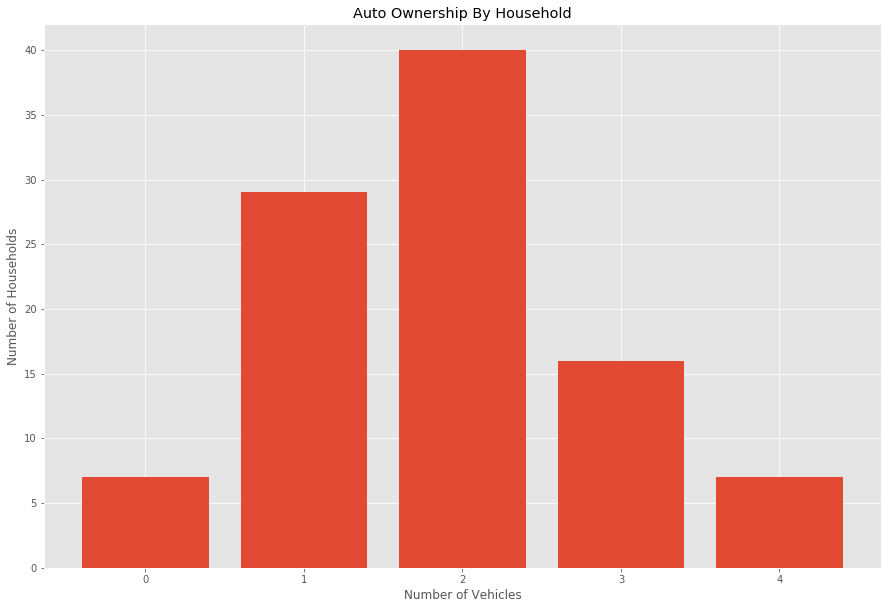

In [9]:
autos = HOUSEHOLD.groupby(["TAZ", "auto_ownership"]).count()["SERIALNO"]
auto_taz = autos.reset_index().pivot_table(index="TAZ", columns="auto_ownership", fill_value=0)

save_verf_csv(auto_taz, 'autos.csv')

auto_counts = autos.groupby(["auto_ownership"]).count()
plt.bar(auto_counts.index, auto_counts.values)
plt.title('Auto Ownership By Household')
plt.ylabel('Number of Households')
_ = plt.xlabel('Number of Vehicles')

# if SP:

#     asim_markets = ["work_low", "work_med", "work_high", "work_high", "work_veryhigh", "university",
#                     "highschool", "gradeschool"]
#     asim = pd.read_csv(asim_sp_work_filename)
#     asim_sch = pd.read_csv(asim_sp_school_filename)
#     asim_sch_no_sp = pd.read_csv(asim_sp_school_no_sp_filename)
#     asim_sch["gradeschool"] = asim_sch_no_sp["gradeschool"]  # grade school not shadow priced
#     asim = asim.set_index("TAZ", drop=False)
#     asim_sch = asim_sch.set_index("TAZ", drop=False)

#     asim["gradeschool"] = asim_sch["gradeschool"].loc[asim["TAZ"]].tolist()
#     asim["highschool"] = asim_sch["highschool"].loc[asim["TAZ"]].tolist()
#     asim["university"] = asim_sch["university"].loc[asim["TAZ"]].tolist()

#     ws_size = asim[["TAZ"]]
#     for i in range(len(asim_markets)):
#         ws_size[asim_markets[i] + "_asim"] = asim[asim_markets[i]]
#     ws_size.to_csv("outputs/asim_work_school_location.csv", na_rep=0)

#     # work county to county flows
#     tazs = pd.read_csv(asim_zones_filename)
#     counties = ["", "SF", "SM", "SC", "ALA", "CC", "SOL", "NAP", "SON", "MAR"]
#     tazs["COUNTYNAME"] = pd.Series(counties)[tazs["county_id"].tolist()].tolist()
#     tazs = tazs.set_index("zone", drop=False)

#     asim_cdap = pd.read_csv(asim_per_filename)
#     asim_cdap["HomeCounty"] = tazs["COUNTYNAME"].loc[asim_cdap["home_taz"]].tolist()
#     asim_cdap["WorkCounty"] = tazs["COUNTYNAME"].loc[asim_cdap["workplace_taz"]].tolist()
#     asim_work_counties = asim_cdap.groupby(["HomeCounty", "WorkCounty"]).count()["household_id"]
#     asim_work_counties = asim_work_counties.reset_index()
#     asim_work_counties = asim_work_counties.pivot(index="HomeCounty", columns="WorkCounty")
#     asim_work_counties.to_csv("outputs/asim_work_counties.csv", na_rep=0)

In [10]:
if SHAPES is not None:
    auto_shapes = SHAPES.merge(autos.reset_index(), how='left', left_on='TAZ1454', right_on='TAZ')
    auto_shapes.plot(column='auto_ownership', cmap='Blues',
                     legend=True,
                     legend_kwds={'label': "Autos per Household"},
                     figsize=(20,20))

Cdap activity by person type

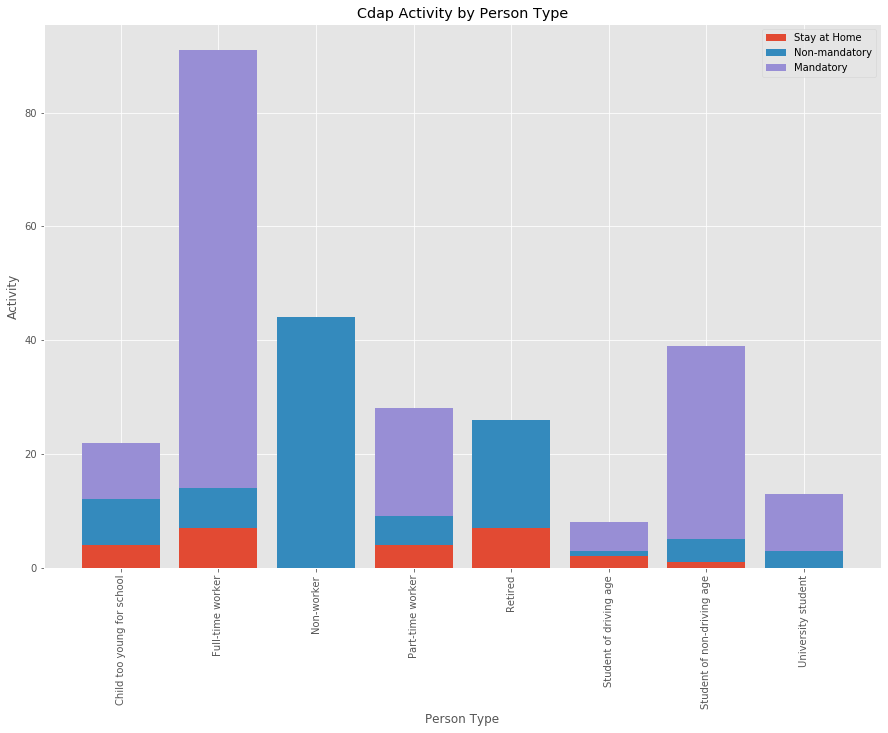

In [11]:
cdap_sum = PERSON.groupby(["ptypename", "cdap_activity"]).count()["household_id"]
cdap_sum = cdap_sum.reset_index().pivot_table(index="ptypename", columns="cdap_activity", fill_value=0)

save_verf_csv(cdap_sum, 'cdap.csv')

stay_at_home = cdap_sum['household_id']['H']
n_mand = cdap_sum['household_id']['N']
mand = cdap_sum['household_id']['M']
plt.bar(cdap_sum.index, stay_at_home, label='Stay at Home')
plt.bar(cdap_sum.index, n_mand, label= 'Non-mandatory', bottom=stay_at_home)
plt.bar(cdap_sum.index, mand, label='Mandatory', bottom=stay_at_home+n_mand)

plt.title('Cdap Activity by Person Type')
plt.ylabel('Activity')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

free parking by ptype

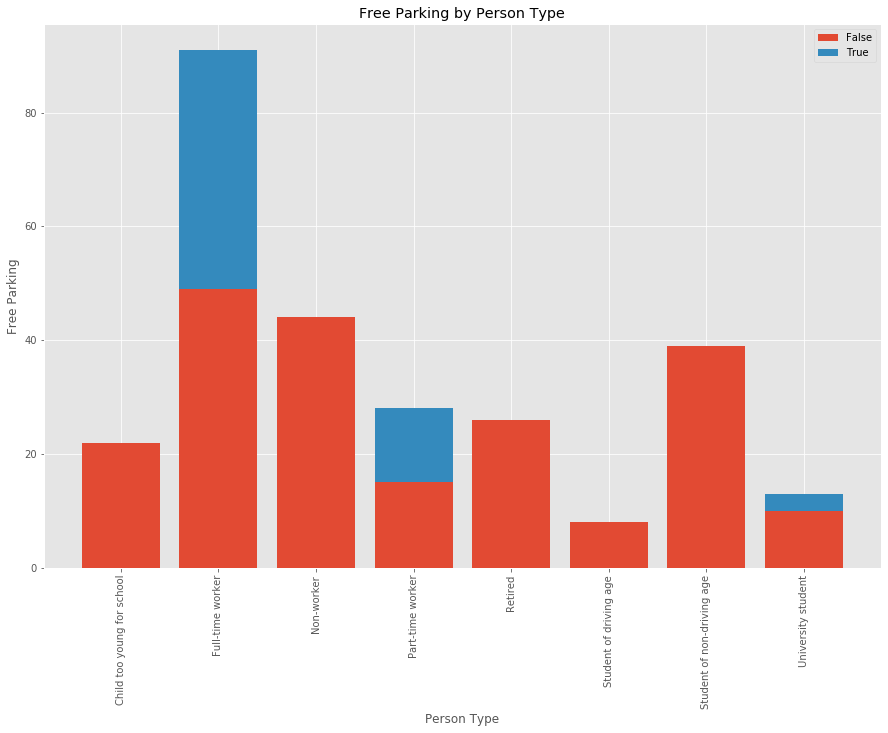

In [12]:
fp = PERSON.groupby(["ptypename", "free_parking_at_work"]).count()["household_id"]
fp = fp.reset_index().pivot_table(index="ptypename", columns="free_parking_at_work", fill_value=0)

save_verf_csv(fp, 'free_parking.csv')

plt.bar(fp.index, fp['household_id'][0], label='False')
plt.bar(fp.index, fp['household_id'][1], label='True', bottom=fp['household_id'][0])
plt.title('Free Parking by Person Type')
plt.ylabel('Free Parking')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

Value of time

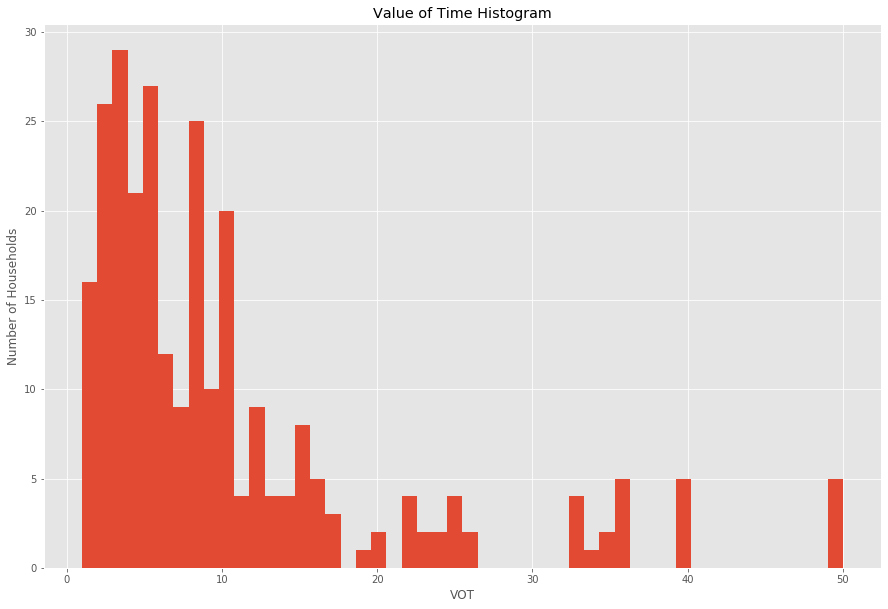

In [13]:
PERSON["vot_bin"] = pd.cut(PERSON["value_of_time"], range(51))
vot = PERSON.groupby(["vot_bin"]).count()["household_id"]

save_verf_csv(vot, 'vot.csv')
plt.hist(PERSON['value_of_time'], bins=50)
plt.title('Value of Time Histogram')
plt.ylabel('Number of Households')
_ = plt.xlabel('VOT')

## Tour

Individual mandatory tour frequency

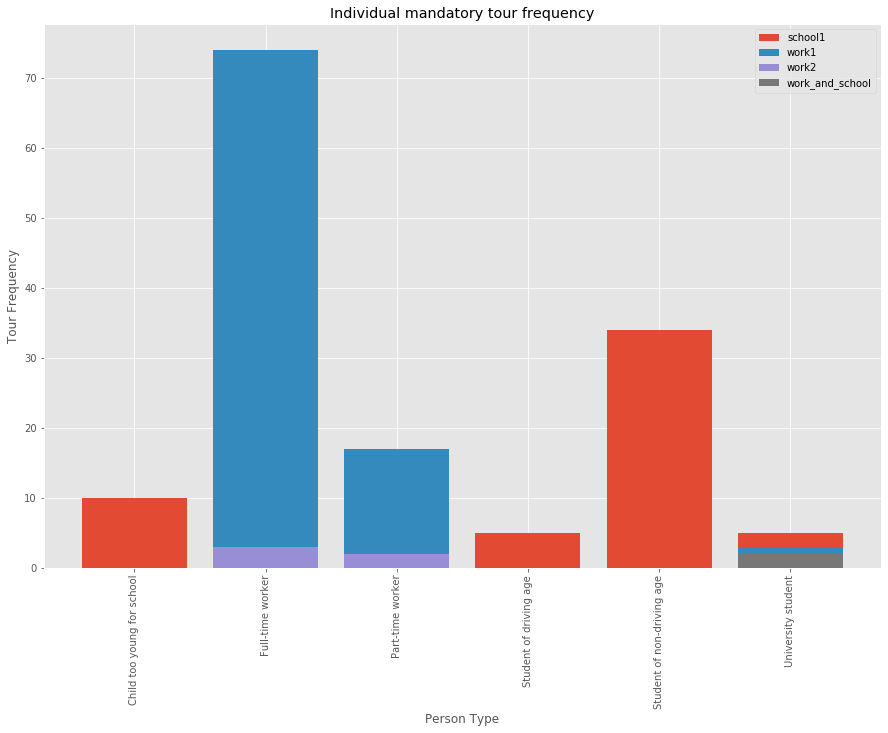

In [14]:
PERSON["hhsize"] = HOUSEHOLD["hhsize"].loc[PERSON["household_id"]].tolist()
imtf = PERSON.groupby(["ptypename", "mandatory_tour_frequency"]).count()["household_id"]
imtf = imtf.reset_index().pivot_table(index="ptypename", columns="mandatory_tour_frequency", fill_value=0)

save_verf_csv(imtf, 'imtf.csv')

for col in imtf['household_id'].columns:
    plt.bar(imtf.index, imtf['household_id'][col], label=col)

plt.title('Individual mandatory tour frequency')
plt.ylabel('Tour Frequency')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

Individual mandatory tour duration

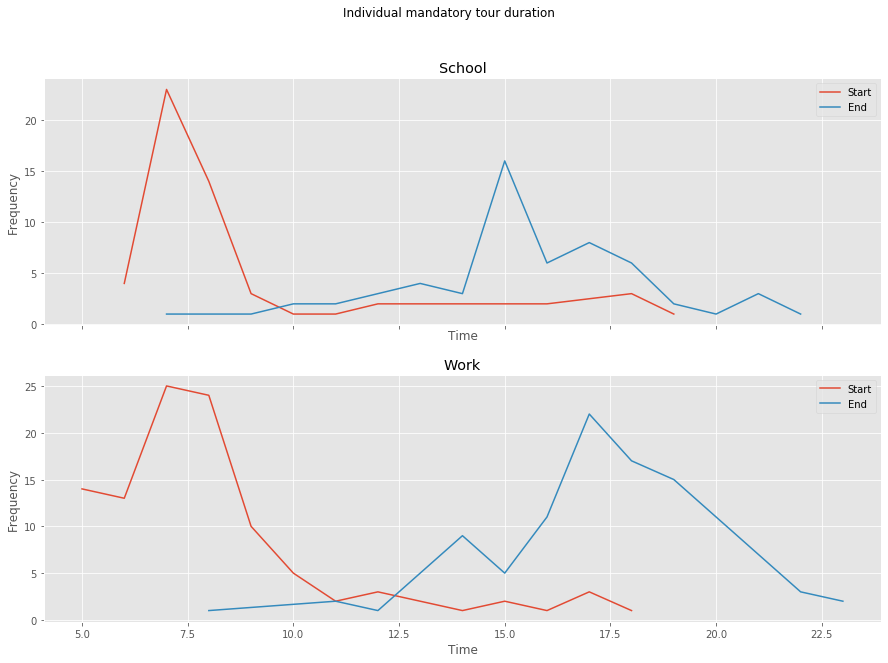

In [15]:
tours_man = TOUR[TOUR["tour_category"] == "mandatory"]
mtdd = tours_man.groupby(["start", "end", "tour_type"]).count()["household_id"].reset_index()

mtdd_sch = mtdd[mtdd["tour_type"] == "school"][[
    "start", "end", "household_id"]].pivot_table(index="start", columns="end", fill_value=0)['household_id']
mtdd_work = mtdd[mtdd["tour_type"] == "work"][[
    "start", "end", "household_id"]].pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(mtdd_sch, 'mtdd_school.csv')
save_verf_csv(mtdd_work, 'mtdd_work.csv')

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Individual mandatory tour duration')
ax1.plot(mtdd_sch.sum(axis=1), label='Start')
ax1.plot(mtdd_sch.sum(axis=0), label='End')
ax1.set_title('School')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time')
ax1.legend(loc='best')

ax2.plot(mtdd_work.sum(axis=1), label='Start')
ax2.plot(mtdd_work.sum(axis=0), label='End')
ax2.set_title('Work')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Time')
_ = ax2.legend(loc='best')

joint tour frequency

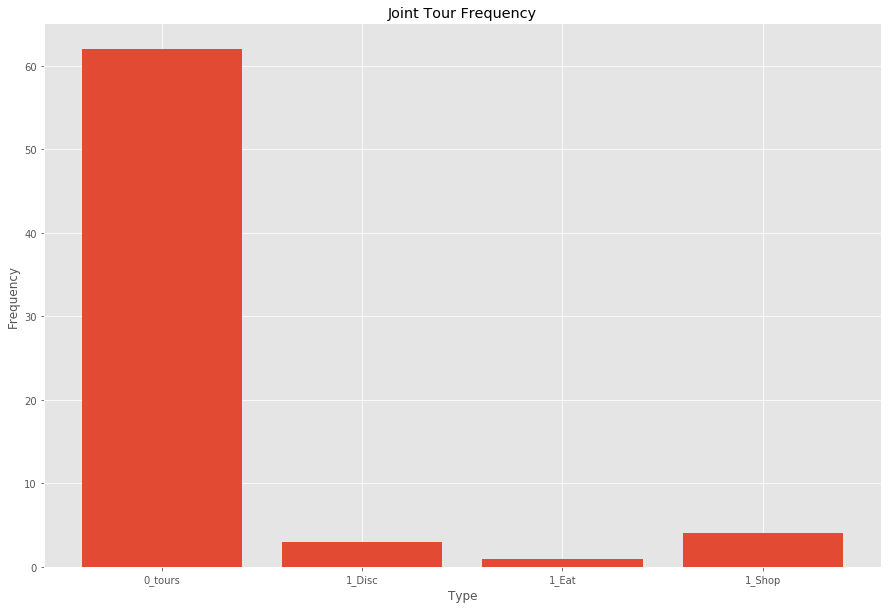

In [16]:
jtf = HOUSEHOLD[HOUSEHOLD['joint_tour_frequency'] != '']
jtf = jtf.reset_index().groupby('joint_tour_frequency').count()['household_id']

save_verf_csv(jtf, 'jtf.csv')
plt.bar(jtf.index, jtf.values)
plt.title('Joint Tour Frequency')
plt.ylabel('Frequency')
_ = plt.xlabel('Type')

joint tour composition

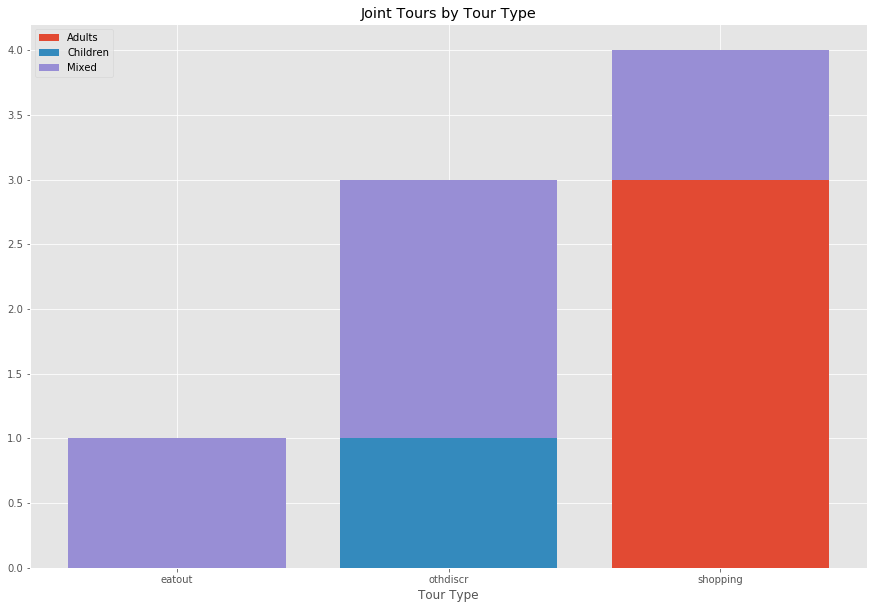

In [17]:
JOINT_TOURS = TOUR[TOUR["tour_category"] == "joint"]
jtour_comp = JOINT_TOURS.groupby(["tour_type", "composition"]).count()["household_id"].reset_index()
jtour_comp = jtour_comp.pivot_table(index="tour_type", columns="composition", fill_value=0)

save_verf_csv(jtour_comp, 'jtour_comp.csv')
adults = jtour_comp['household_id']['adults']
children = jtour_comp['household_id']['children']
mixed = jtour_comp['household_id']['mixed']
plt.bar(jtour_comp.index, adults, label='Adults')
plt.bar(jtour_comp.index, children, label='Children', bottom = adults)
plt.bar(jtour_comp.index, mixed, label='Mixed', bottom = adults+children)
plt.title('Joint Tours by Tour Type')
plt.xlabel('Tour Type')
_ = plt.legend(loc='best')

joint tour destination

/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


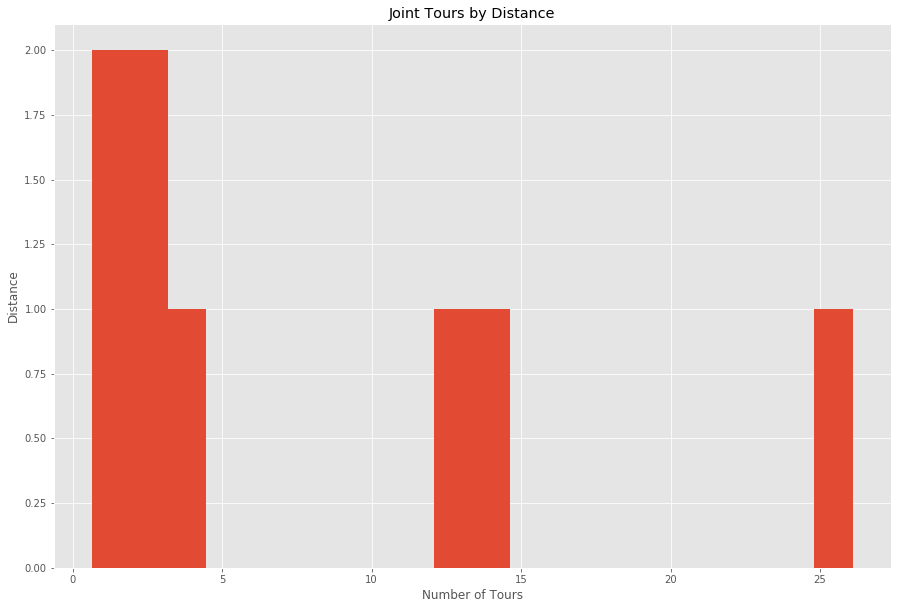

In [18]:
JOINT_TOURS["distance"] = DIST_MAT[JOINT_TOURS["origin"].astype(int)-1,
                                   JOINT_TOURS["destination"].astype(int)-1]
JOINT_TOURS["dist_bin"] = pd.cut(JOINT_TOURS["distance"], range(21))
jtours_dist = JOINT_TOURS.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(jtours_dist, 'jtour_dist.csv')
plt.hist(JOINT_TOURS["distance"], bins=20)
plt.title('Joint Tours by Distance')
plt.ylabel('Distance')
_ = plt.xlabel('Number of Tours')

joint tour tdd

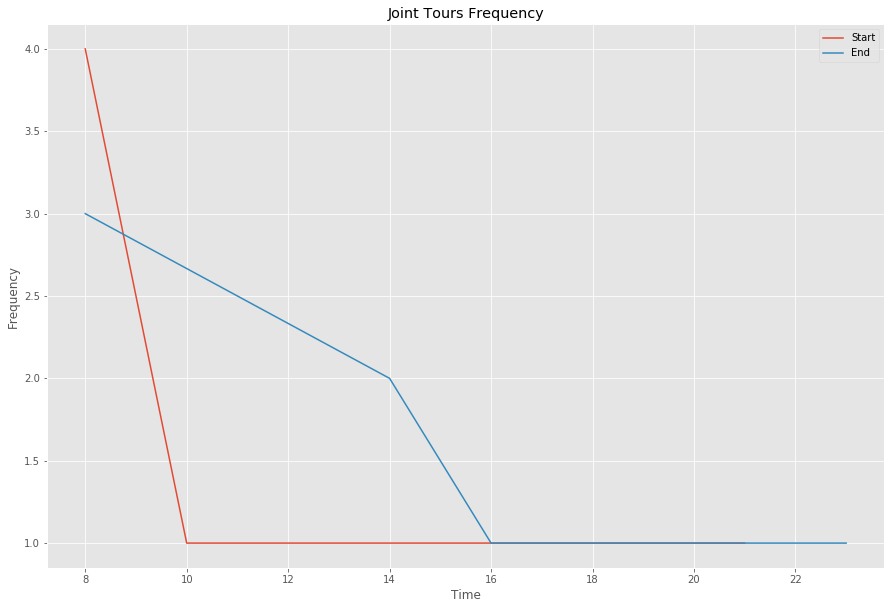

In [19]:
jtours_tdd = JOINT_TOURS.groupby(["start", "end"]).count()["household_id"].reset_index()
jtours_tdd = jtours_tdd.pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(jtours_tdd, 'jtours_tdd.csv')

plt.plot(jtours_tdd.sum(axis=1), label='Start')
plt.plot(jtours_tdd.sum(axis=0), label='End')
plt.title('Joint Tours Frequency')
plt.ylabel('Frequency')
plt.xlabel('Time')
_ = plt.legend(loc='best')

Non-mandatory tour frequency

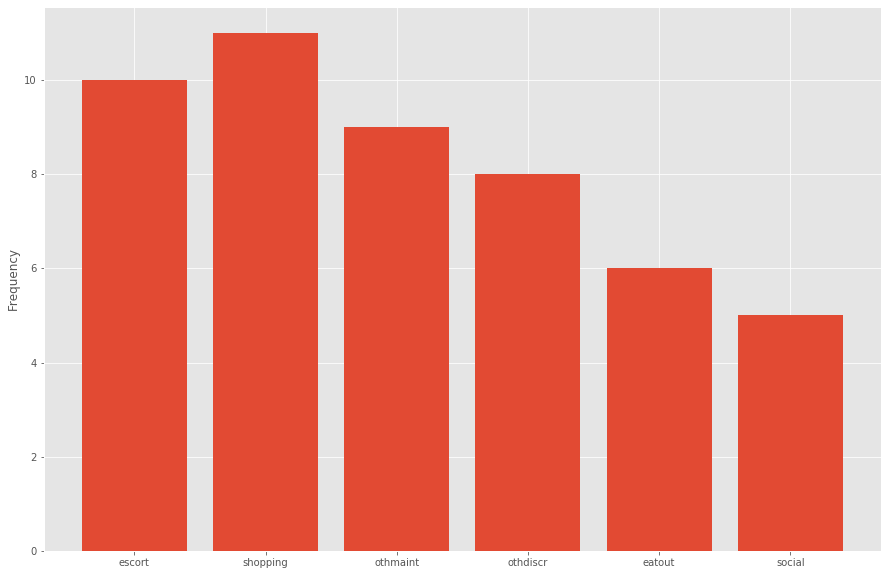

In [20]:
alts = pd.read_csv(NMTF_ALTS_FILE)
alts["ID"] = range(len(alts))

nmtf_sum = PERSON.groupby(["non_mandatory_tour_frequency"]).count()["household_id"]
nmtf_alts = pd.concat([alts, nmtf_sum], axis=1).dropna()

save_verf_csv(nmtf_alts, 'nmtf.csv')
nmtf = nmtf_alts.drop(['ID', 'household_id'], axis=1).sum()
plt.bar(nmtf.index, nmtf.values)
_ = plt.ylabel('Frequency')

Non-mandatory tour destination

/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


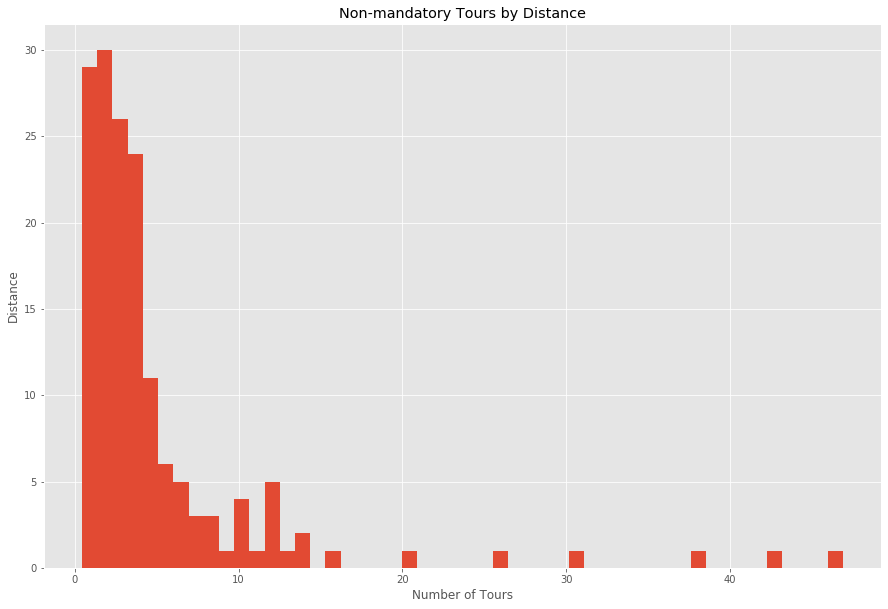

In [21]:
nm_tours = TOUR[TOUR["tour_category"] == "non_mandatory"]
nm_tours["distance"] = DIST_MAT[nm_tours["origin"].astype(int)-1,
                                nm_tours["destination"].astype(int)-1]
nm_tours["dist_bin"] = pd.cut(nm_tours["distance"], range(51))
nm_tours_dist = nm_tours.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(nm_tours_dist, 'nmtd_dist.csv')
plt.hist(nm_tours["distance"], bins=50)
plt.title('Non-mandatory Tours by Distance')
plt.ylabel('Distance')
_ = plt.xlabel('Number of Tours')

In [22]:
if SHAPES is not None:
    nmtours_dests = nm_tours.groupby(['destination']).count()['household_id']
    nmtours_shapes = SHAPES.merge(nmtours_dests.reset_index(), how='left', left_on='TAZ1454', right_on='destination')
    nmtours_shapes.plot(column='household_id', 
                        cmap='Blues',
                        figsize=(20,20),
                        legend=True,
                        legend_kwds={'label': 'Non-mandatory Trip Destination Frequency'})

Non-mandatory tour scheduling

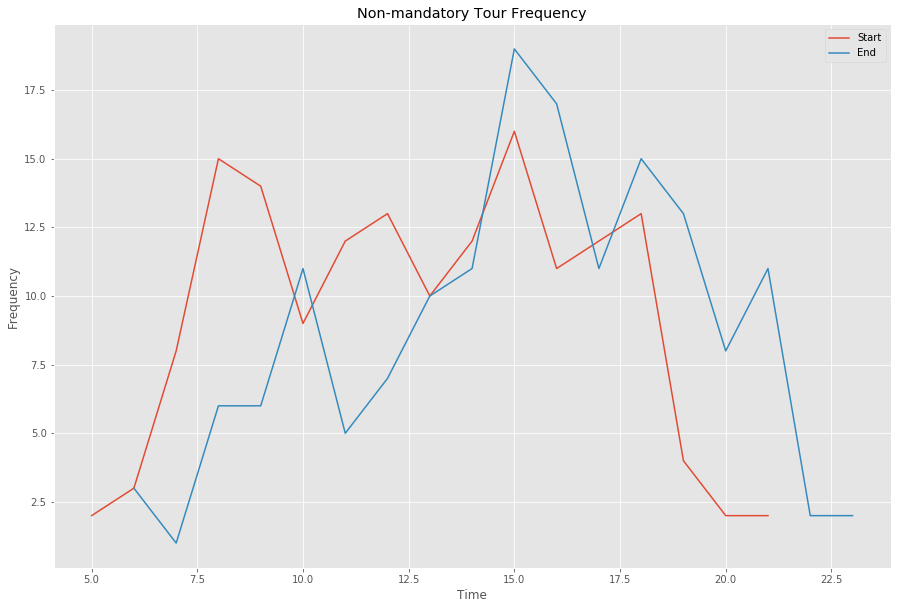

In [23]:
nmtours_tdd = nm_tours.groupby(["start", "end"]).count()["household_id"].reset_index()
nmtours_tdd = nmtours_tdd.pivot_table(index="start", columns="end", fill_value=0)["household_id"]

save_verf_csv(nmtours_tdd, 'nmtours_tdd.csv')

plt.plot(nmtours_tdd.sum(axis=1), label='Start')
plt.plot(nmtours_tdd.sum(axis=0), label='End')
plt.title('Non-mandatory Tour Frequency')
plt.ylabel('Frequency')
plt.xlabel('Time')
_ = plt.legend(loc='best')

Tour mode choice

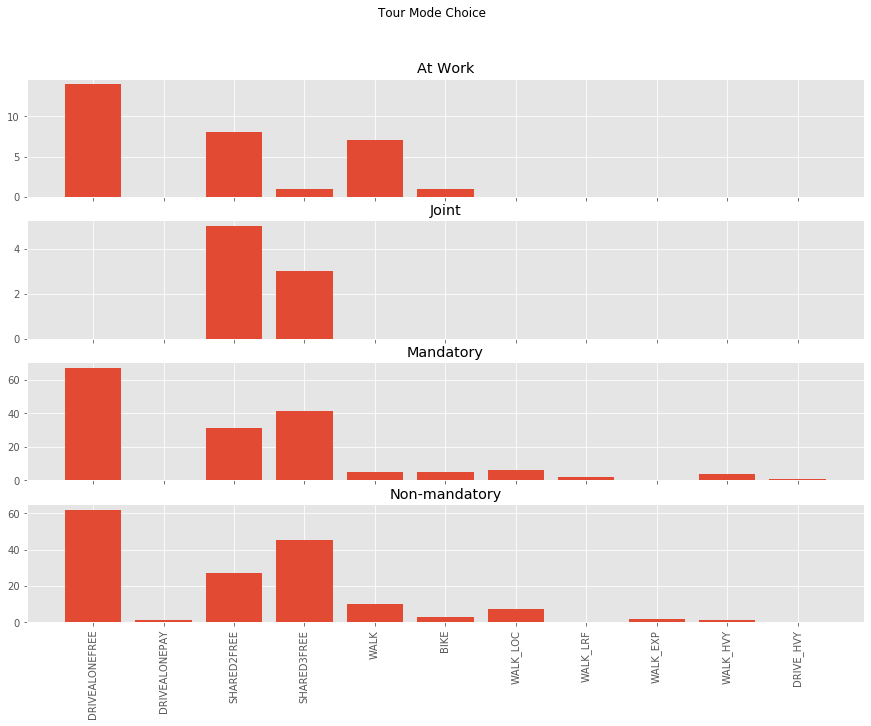

In [24]:
tour_mode = TOUR.groupby(["tour_mode", "tour_category"]).count()["household_id"].reset_index()
tour_mode = tour_mode.pivot_table(index="tour_mode", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(tour_mode, 'tour_mode.csv')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Tour Mode Choice')
ax1.bar(tour_mode.index, tour_mode['atwork'])
ax1.set_title('At Work')
ax2.bar(tour_mode.index, tour_mode['joint'])
ax2.set_title('Joint')
ax3.bar(tour_mode.index, tour_mode['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(tour_mode.index, tour_mode['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')

At-work subtour frequency 

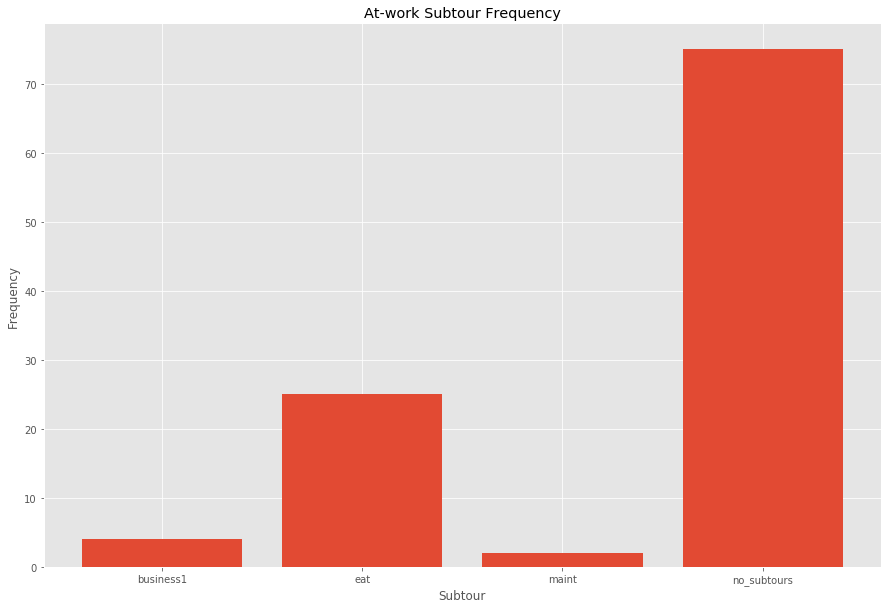

In [25]:
work_tours = TOUR[TOUR["primary_purpose"] == "work"]
work_tours = work_tours.groupby(["atwork_subtour_frequency"]).count()["household_id"]

save_verf_csv(work_tours, 'atwork_tf.csv')
plt.bar(work_tours.index, work_tours.values)
plt.title('At-work Subtour Frequency')
plt.xlabel('Subtour')
_ = plt.ylabel('Frequency')

At-work subtour destination

/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/envs/asimtest/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


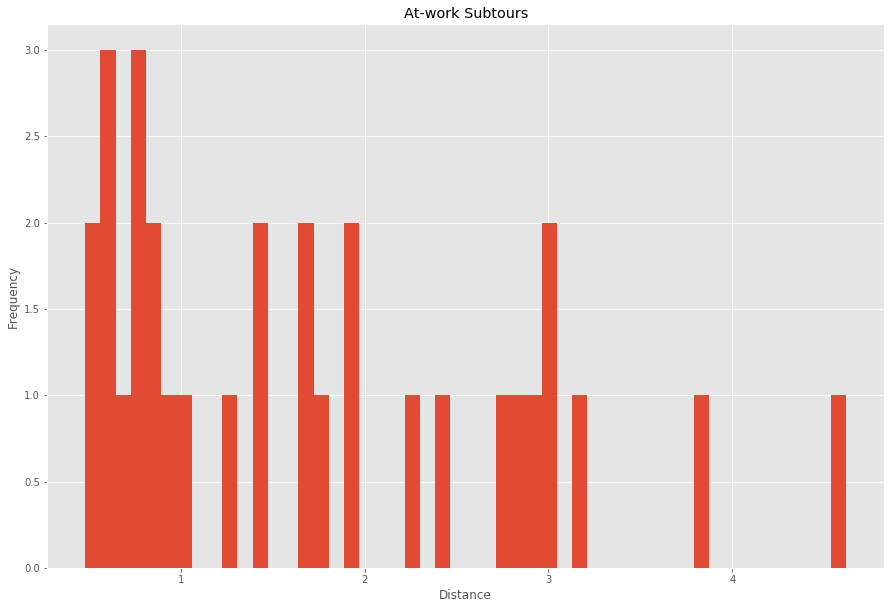

In [26]:
ATW_TOURS = TOUR[TOUR["tour_category"] == "atwork"]
ATW_TOURS["distance"] = DIST_MAT[ATW_TOURS["origin"].astype(int)-1,
                                 ATW_TOURS["destination"].astype(int)-1]
ATW_TOURS["dist_bin"] = pd.cut(ATW_TOURS["distance"], range(51))
atw_tours_dist = ATW_TOURS.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(atw_tours_dist, 'atwork_dist.csv')
plt.hist(ATW_TOURS["distance"], bins=50)
plt.title('At-work Subtours')
plt.ylabel('Frequency')
_ = plt.xlabel('Distance')

At-work subtour scheduling

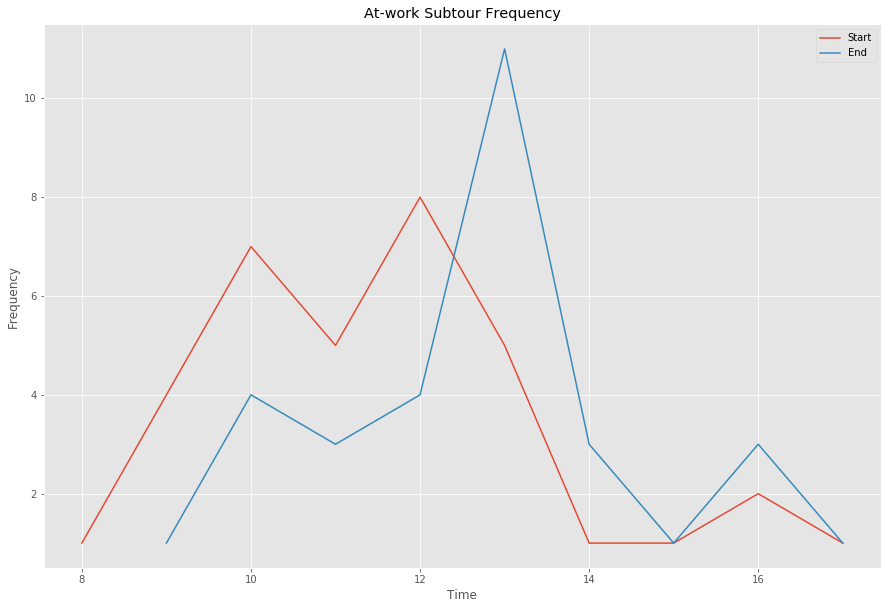

In [27]:
atw_tours_tdd = ATW_TOURS.groupby(["start", "end"]).count()["household_id"].reset_index()
atw_tours_tdd = atw_tours_tdd.pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(atw_tours_tdd, 'atwork_tours_tdd.csv')

plt.plot(atw_tours_tdd.sum(axis=1), label='Start')
plt.plot(atw_tours_tdd.sum(axis=0), label='End')
plt.title('At-work Subtour Frequency')
plt.ylabel('Frequency')
plt.xlabel('Time')
_ = plt.legend(loc='best')

At-work subtour mode choice - see tour mode above

Tour stop frequency

In [28]:
nmn_tours = TOUR[(TOUR["tour_category"] == "mandatory") |
                 (TOUR["tour_category"] == "non_mandatory")]
stop_freq = nmn_tours.groupby(["stop_frequency", "tour_type"]).count()["household_id"].reset_index()
stop_freq = stop_freq.pivot(index="stop_frequency", columns="tour_type")

stop_freq_joint = JOINT_TOURS.groupby(["stop_frequency"]).count()["household_id"]
stop_freq_atwork = ATW_TOURS.groupby(["stop_frequency"]).count()["household_id"]
stop_freq = pd.concat([stop_freq, stop_freq_joint, stop_freq_atwork], axis=1, sort=True)

save_verf_csv(stop_freq, 'stop_freq.csv')

## Trips

Trip purpose

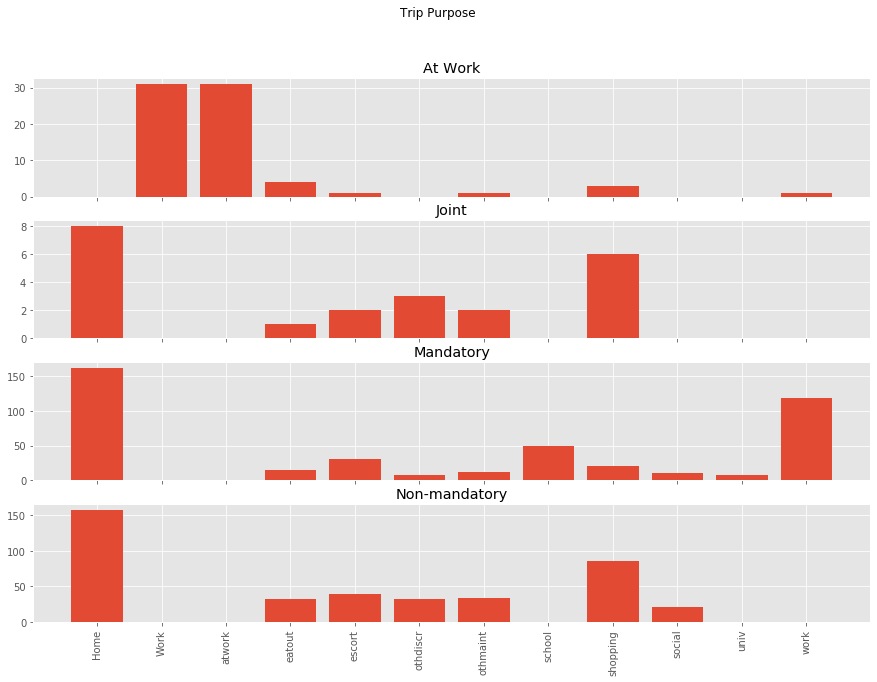

In [29]:
TRIP["tour_category"] = TOUR["tour_category"].loc[TRIP["tour_id"]].tolist()
trip_purp = TRIP.groupby(["purpose", "tour_category"]).count()["household_id"].reset_index()
trip_purp = trip_purp.pivot_table(index="purpose", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(trip_purp, 'trip_purp.csv')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Trip Purpose')
ax1.bar(trip_purp.index, trip_purp['atwork'])
ax1.set_title('At Work')
ax2.bar(trip_purp.index, trip_purp['joint'])
ax2.set_title('Joint')
ax3.bar(trip_purp.index, trip_purp['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(trip_purp.index, trip_purp['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')

Trip Destination

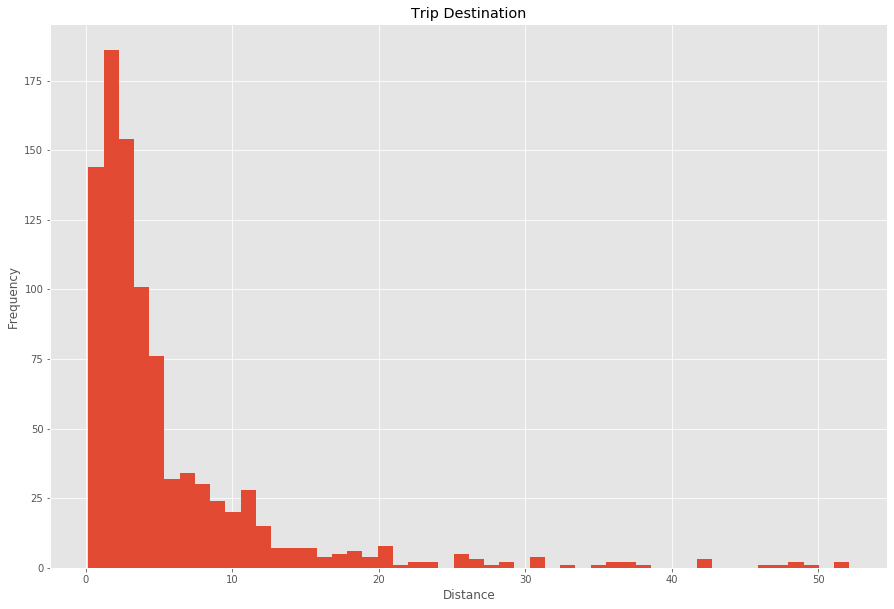

In [30]:
TRIP["distance"] = DIST_MAT[TRIP["origin"]-1, TRIP["destination"]-1]
TRIP["dist_bin"] = pd.cut(TRIP["distance"], range(51))
trips_dist = TRIP.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(trips_dist, 'trips_dist.csv')
plt.hist(TRIP["distance"], bins=50)
plt.title('Trip Destination')
plt.ylabel('Frequency')
_ = plt.xlabel('Distance')

In [31]:
if SHAPES is not None:
    trip_dests = TRIP.groupby(['destination']).count()['household_id']
    trip_shapes = SHAPES.merge(trip_dests.reset_index(), how='left', left_on='TAZ1454', right_on='destination')
    trip_shapes.plot(column='household_id',
                     cmap='Blues',
                     figsize=(20,20),
                     legend=True,
                     legend_kwds={'label': 'Trip Destination Frequency', 'orientation': "horizontal"})

Trip scheduling

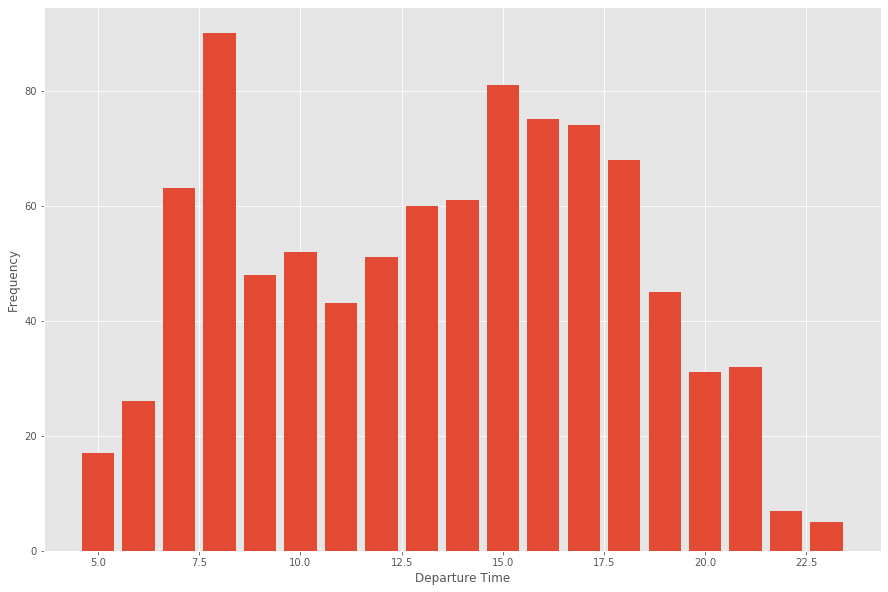

In [32]:
trips_tdd = TRIP.groupby(["depart"]).count()["household_id"]

save_verf_csv(trips_tdd, 'asim_trips_depart.csv')
plt.bar(trips_tdd.index, trips_tdd.values)
plt.xlabel('Departure Time')
_ = plt.ylabel('Frequency')

Trip mode share by tour purpose

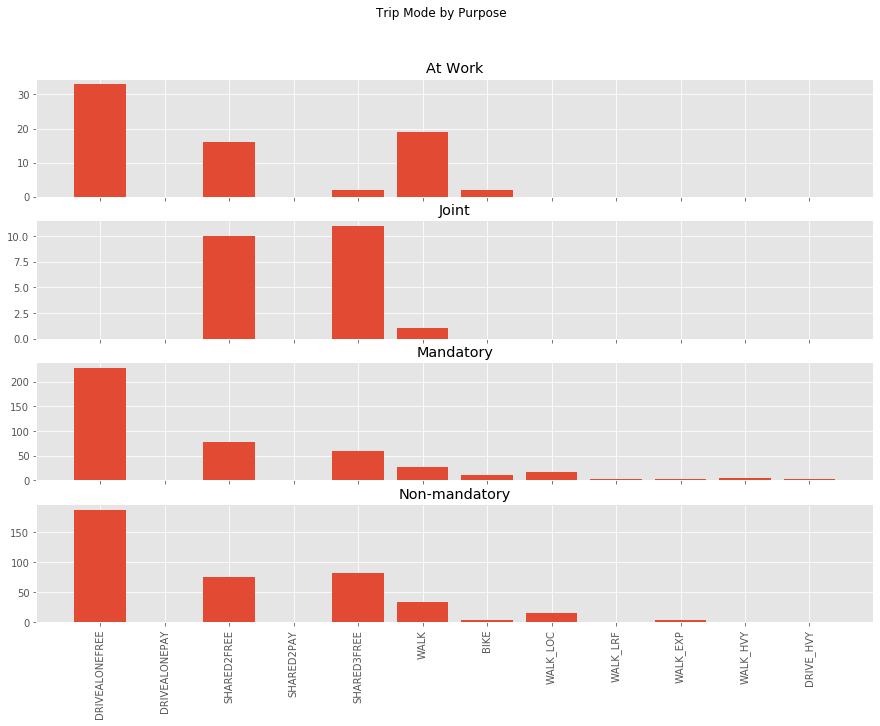

In [33]:
trip_mode = TRIP.groupby(["trip_mode", "tour_category"]).count()["household_id"].reset_index()
trip_mode = trip_mode.pivot_table(index="trip_mode", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(trip_mode, 'trip_mode.csv')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Trip Mode by Purpose')
ax1.bar(trip_mode.index, trip_mode['atwork'])
ax1.set_title('At Work')
ax2.bar(trip_mode.index, trip_mode['joint'])
ax2.set_title('Joint')
ax3.bar(trip_mode.index, trip_mode['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(trip_mode.index, trip_mode['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')